# Predicting Covid19 using lung CT scans

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**


![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/covid_chest.gif)

Using the Lung CT scans to predict whether a person has COVID 19.

Deep learning models have proven useful and very efficient in the medical field to process scans, x-rays and other medical information to output useful information.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import os
import random

## Dataset

In [2]:
!wget -N https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/COVID_CT_SCAN.zip
!unzip -qo COVID_CT_SCAN.zip
!rm COVID_CT_SCAN.zip

--2020-10-21 19:08:22--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/COVID_CT_SCAN.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.80
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97368158 (93M) [application/zip]
Saving to: ‘COVID_CT_SCAN.zip’

COVID_CT_SCAN.zip   100%[===================>]  92.86M   101MB/s    in 0.9s    

2020-10-21 19:08:23 (101 MB/s) - ‘COVID_CT_SCAN.zip’ saved [97368158/97368158]



The dataset has the following:

    * CT_COVID - This folder has images corresponding to a positive case of the COVID.
    
    * CT_NonCOVID - This folder has images corresponding to a negative case of the COVID.
    
    * A xlsx file - Contains the meta dat of the images.

In [3]:
data_dir = 'COVID_CT_SCAN'

print("Number of samples")
for f in os.listdir(data_dir + '/'):
    if os.path.isdir(data_dir + '/' + f):
        print(f, " : ", len(os.listdir(data_dir + '/' + f +'/')))

Number of samples
CT_NonCOVID  :  397
CT_COVID  :  349


Its an almost balanced dataset.

In [4]:
batch_size = 64

print("Training set")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=113, 
  batch_size=batch_size)

print("Validation set")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=113, 
  batch_size=batch_size)

Training set
Found 746 files belonging to 2 classes.
Using 597 files for training.
Validation set
Found 746 files belonging to 2 classes.
Using 149 files for validation.


Looking into the classes

In [5]:
class_names = train_ds.class_names
print(class_names)

['CT_COVID', 'CT_NonCOVID']


## Visualization

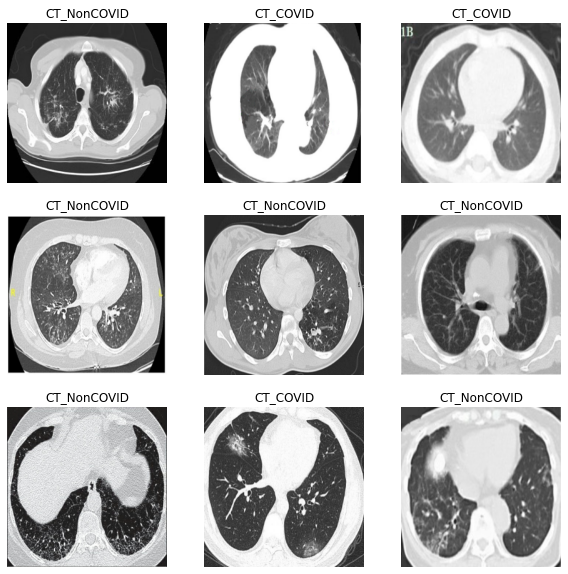

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
print("Shape of one training batch")

for image_batch, labels_batch in train_ds:
    print("Input: ", image_batch.shape)
    print("Labels: ", labels_batch.shape)
    break

Shape of one training batch
Input:  (64, 256, 256, 3)
Labels:  (64,)


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Normalizing the pixel values

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Model

In [10]:
model = tf.keras.models.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape = (256, 256, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation = 'relu'),  
  layers.Dense(1, activation = 'sigmoid')
])

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

epochs=16
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/16
10/10 [==============================] - 16s 2s/step - loss: 0.8728 - accuracy: 0.5360 - val_loss: 0.6454 - val_accuracy: 0.6376
Epoch 2/16
10/10 [==============================] - 14s 1s/step - loss: 0.6177 - accuracy: 0.6734 - val_loss: 0.5655 - val_accuracy: 0.6846
Epoch 3/16
10/10 [==============================] - 14s 1s/step - loss: 0.5698 - accuracy: 0.7236 - val_loss: 0.6447 - val_accuracy: 0.6376
Epoch 4/16
10/10 [==============================] - 14s 1s/step - loss: 0.4960 - accuracy: 0.7672 - val_loss: 0.5311 - val_accuracy: 0.6913
Epoch 5/16
10/10 [==============================] - 14s 1s/step - loss: 0.4415 - accuracy: 0.7956 - val_loss: 0.6232 - val_accuracy: 0.6711
Epoch 6/16
10/10 [==============================] - 14s 1s/step - loss: 0.4080 - accuracy: 0.8258 - val_loss: 0.4910 - val_accuracy: 0.7450
Epoch 7/16
10/10 [==============================] - 14s 1s/step - loss: 0.3558 - accuracy: 0.8392 - val_loss: 0.4903 - val_accuracy: 0.7450
Epoch 8/16
10/10 [==

In [12]:
model.evaluate(val_ds)

3/3 [==============================] - 1s 196ms/step - loss: 0.9170 - accuracy: 0.6980


[0.9169734716415405, 0.6979866027832031]

There is a difference in accuracy between the train and validation accuracy. 
This high variance can be reducesd by training with a larger dataset, thus resulting in higher accuracy. 

## Plotting the metrics

In [13]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.title(variable)

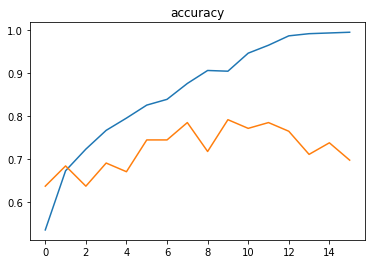

In [14]:
plot(history.history, "accuracy", 'val_accuracy')

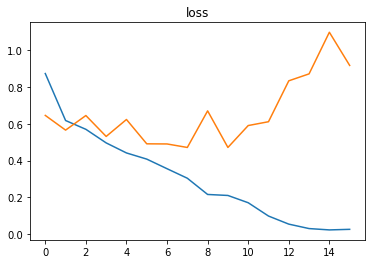

In [15]:
plot(history.history, "loss", "val_loss")

## Prediction

Prdicted:  CT_COVID
True:  CT_COVID
Probability:  0.80769587


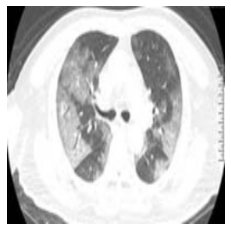

In [16]:
# pick random test data sample from one batch
x = random.randint(0, batch_size - 1)

for i in val_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (64, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Prdicted: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

## deepC

In [17]:
model.save('lungct.h5')

!deepCC lungct.h5

reading [keras model] from 'lungct.h5'
Saved 'lungct.onnx'
reading onnx model from file  lungct.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): graph-node conv2d's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_2's attribute auto_pad has no meaningful data.
WARN (ONNX): terminal (input/output) conv2d_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_2's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_2) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  lungct_deepC/lungct.cpp
INFO (ONNX): model files are ready in dir lungct_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg

True:  CT_NonCOVID
reading file sample.data.
Warn: conv2d_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_1_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_2_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
writing file dense_2.out.
Model predicted:  0.999998  -->  1


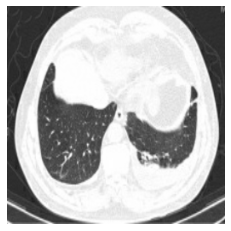

In [19]:
# pick random test data sample from the batch
x = random.randint(0, batch_size - 1)

for i in val_ds.as_numpy_iterator():    
    img, label = i      # i contains all test samples
    np.savetxt('sample.data', (img[x]).flatten())    # xth sample into text file
    plt.axis('off')
    plt.imshow(img[x])
    print("True: ", class_names[label[x]])
    break

# run exe with input
!lungct_deepC/lungct.exe sample.data

# show predicted output
nn_out = np.loadtxt('dense_2.out')
#print(class_names, nn_out)
print ("Model predicted: ", nn_out, " --> ", int(nn_out>0.5))
